### Author : Swapnoneel Kayal <br>
References Used :      


*   For guidance in understanding key concepts : https://medium.com/analytics-vidhya/how-esrgan-improves-super-resolution-performance-15de91d77ada


In [ ]:
import numpy as np
import pandas as pd 
import os

In [ ]:
import cv2

def load(path,shape):
    img= cv2.imread(path)
    img= cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img= cv2.resize(img, shape)
    return img

In [ ]:
low_shape = (96, 96, 3)
high_shape = (384, 384, 3)

In [ ]:
import glob

def get_data(directory):
    X = []
    y = []
    for folder in glob.glob(directory+ str('/*')):
        for img_path in glob.glob(folder+ str('/*')):      
            if folder == os.path.join(directory, 'HR'):
                X.append(load(img_path, low_shape[:-1]))
            elif folder == os.path.join(directory, 'LR'):
                y.append(load(img_path, high_shape[:-1]))

    X = np.array(X)
    y = np.array(y)
    return X, y

In [ ]:
LR_train, HR_train = get_data('/content/drive/MyDrive/EE769_Project/ESRGAN/data')
LR_train.shape, HR_train.shape

((100, 96, 96, 3), (100, 384, 384, 3))

In [ ]:
from sklearn.model_selection import train_test_split

LR_train, LR_val, HR_train, HR_val = train_test_split(LR_train, HR_train, test_size=0.1)
print(LR_train.shape, HR_train.shape)
print(LR_val.shape, HR_val.shape)

(90, 96, 96, 3) (90, 384, 384, 3)
(10, 96, 96, 3) (10, 384, 384, 3)


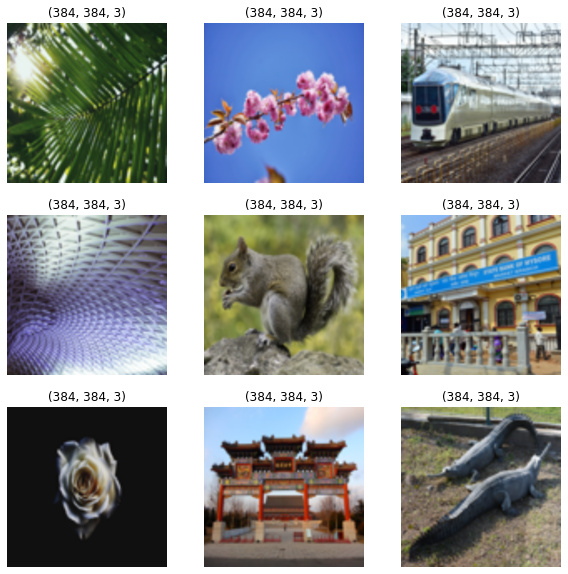

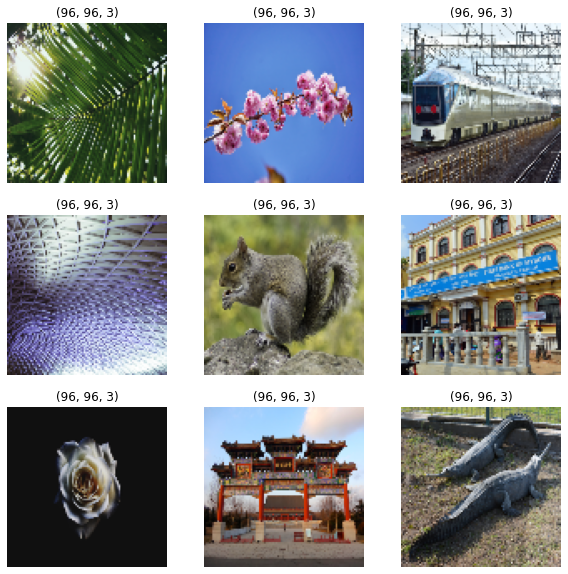

In [ ]:
import matplotlib.pyplot as plt

lowres, highres = LR_train[:9], HR_train[:9]

# Hight Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(highres[i])
    plt.title(highres[i].shape)
    plt.axis("off")

# Low Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(lowres[i])
    plt.title(lowres[i].shape)
    plt.axis("off")


def PSNR(super_resolution, high_resolution):
    """Compute the peak signal-to-noise ratio, measures quality of image."""
    # Max value of pixel is 255
    psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=255)[0]
    return psnr_value

In [ ]:
import tensorflow as tf
from keras.layers import BatchNormalization, GlobalAvgPool2D, LeakyReLU, Lambda
from keras.layers import Conv2D, Dense, Add, Rescaling
from tensorflow.nn import depth_to_space
from keras import Model
from keras import Input

class ESRGAN(object):
    def generator(scaling_factor, feature_maps, residual_blocks, leaky_alpha, 
                  residual_scalar):
        input_layer = Input((None, None, 3))
        xIn = Rescaling(scale=1.0/255, offset=0.0)(input_layer)

        xIn = Conv2D(filters=feature_maps, kernel_size=9, padding="same")(xIn)
        xIn = LeakyReLU(leaky_alpha)(xIn)

        # construct the residual in residual block
        x = Conv2D(filters=feature_maps, kernel_size=3, padding="same")(xIn)
        x1 = LeakyReLU(leaky_alpha)(x)
        x1 = Add()([xIn, x1])

        x = Conv2D(filters=feature_maps, kernel_size=3, padding="same")(x1)
        x2 = LeakyReLU(leaky_alpha)(x)
        x2 = Add()([x1, x2])

        x = Conv2D(filters=feature_maps, kernel_size=3, padding="same")(x2)
        x3 = LeakyReLU(leaky_alpha)(x)
        x3 = Add()([x2, x3])

        x = Conv2D(filters=feature_maps, kernel_size=3, padding="same")(x3)
        x4 = LeakyReLU(leaky_alpha)(x)
        x4 = Add()([x3, x4])
        x4 = Conv2D(filters=feature_maps, kernel_size=3, padding="same")(x4)

        xSkip = Add()([xIn, x4])

        # scale the residual outputs with a scalar between [0,1]
        xSkip = Lambda(lambda x: x * residual_scalar)(xSkip)

        # create a number of residual in residual blocks
        for blockId in range(residual_blocks-1):
            x = Conv2D(filters=feature_maps, kernel_size=3, padding="same")(xSkip)
            x1 = LeakyReLU(leaky_alpha)(x)
            x1 = Add()([xSkip, x1])

            x = Conv2D(filters=feature_maps, kernel_size=3, padding="same")(x1)
            x2 = LeakyReLU(leaky_alpha)(x)
            x2 = Add()([x1, x2])

            x = Conv2D(filters=feature_maps, kernel_size=3, padding="same")(x2)
            x3 = LeakyReLU(leaky_alpha)(x)
            x3 = Add()([x2, x3])

            x = Conv2D(filters=feature_maps, kernel_size=3, padding="same")(x3)
            x4 = LeakyReLU(leaky_alpha)(x)
            x4 = Add()([x3, x4])
            x4 = Conv2D(filters=feature_maps, kernel_size=3, padding="same")(x4)

            xSkip = Add()([xSkip, x4])
            xSkip = Lambda(lambda x: x * residual_scalar)(xSkip)

        x = Conv2D(filters=feature_maps, kernel_size=3, padding="same")(xSkip)
        x = Add()([xIn, x])

        # upscale the image with pixel shuffle
        x = Conv2D(filters=feature_maps * (scaling_factor // 2), kernel_size=3, 
                   padding="same")(x)
        x = tf.nn.depth_to_space(x, 2)
        x = LeakyReLU(leaky_alpha)(x)

        # upscale the image with pixel shuffle
        x = Conv2D(filters=feature_maps, kernel_size=3, padding="same")(x)
        x = tf.nn.depth_to_space(x, 2)
        x = LeakyReLU(leaky_alpha)(x)

        x = Conv2D(filters=3, kernel_size=9, padding="same", activation="tanh")(x)
        output_layer = Rescaling(scale=127.5, offset=127.5)(x)

        generator = Model(inputs=input_layer, outputs=output_layer)

        return generator

    def discriminator(feature_maps, leaky_alpha, disc_blocks):
        input_layer = Input((None, None, 3))

        x = Rescaling(scale=1.0/127.5, offset=-1)(input_layer)
        x = Conv2D(filters=feature_maps, kernel_size=3, padding="same")(x)
        x = LeakyReLU(leaky_alpha)(x)

        x = Conv2D(filters=feature_maps, kernel_size=3, padding="same")(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(leaky_alpha)(x)

    # create a downsample conv kernel config
        downConvConf = {
            "strides": (2,2),
            "padding": "same",
        }

        # create a number of discriminator blocks
        for i in range(1, disc_blocks):

            x = Conv2D(filters=feature_maps * (2 ** i), kernel_size=3, **downConvConf)(x)
            x = BatchNormalization()(x)
            x = LeakyReLU(leaky_alpha)(x)

            x = Conv2D(filters=feature_maps * (2 ** i), kernel_size=3, padding="same")(x)
            x = BatchNormalization()(x)
            x = LeakyReLU(leaky_alpha)(x)

        x = GlobalAvgPool2D()(x)
        x = LeakyReLU(leaky_alpha)(x)
        output_layer = Dense(1, activation="sigmoid")(x)

        discriminator = Model(inputs=input_layer, outputs=output_layer)

        return discriminator

In [ ]:
from keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow import reduce_mean
from tensorflow.keras.losses import Reduction

class Losses:
    def __init__(self):
        pass
    
    def bce_loss(self, real, pred):
        bce = BinaryCrossentropy(reduction=Reduction.NONE)
        loss = bce(real, pred)
        loss = reduce_mean(loss)
        return loss
    
    def mse_loss(self, real, pred):
        mse = MeanSquaredError(reduction=Reduction.NONE)
        loss = mse(real, pred)
        loss = reduce_mean(loss)
        return loss

In [ ]:
from tensorflow import concat, zeros, GradientTape, ones
from keras.activations import sigmoid
from tensorflow.math import reduce_mean

class ESRGANTraining(Model):
    def __init__(self, generator, discriminator, vgg, batch_size):
        super().__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.vgg = vgg
        self.batch_size = batch_size
    def compile(self, generator_optimizer, discriminator_optimizer, bce_loss, mse_loss):
        super().compile()
        self.generator_optimizer = generator_optimizer
        self.discriminator_optimizer = discriminator_optimizer

        self.bce_loss = bce_loss
        self.mse_loss = mse_loss
    
    def train_step(self, images):
        (lr_images, hr_images) = images
        lr_images = tf.cast(lr_images, tf.float32)
        hr_images = tf.cast(hr_images, tf.float32)

        sr_images = self.generator(lr_images)
        combined_images = concat([sr_images, hr_images], axis=0)
        labels = concat([zeros((self.batch_size, 1)), ones((self.batch_size, 1))], axis=0)
        
        with GradientTape() as tape:
            raw_preds = self.discriminator(combined_images)
            raw_fake = raw_preds[:self.batch_size]
            raw_real = raw_preds[self.batch_size:]

            predFake = sigmoid(raw_fake - reduce_mean(raw_real)) 
            predReal = sigmoid(raw_real - reduce_mean(raw_fake))

            predictions = concat([predFake, predReal], axis=0)
            d_loss = self.bce_loss(labels, predictions)

        grads = tape.gradient(d_loss, self.discriminator.trainable_variables)

        self.discriminator_optimizer.apply_gradients(zip(grads, 
                                                         self.discriminator.trainable_variables))
        miss_leading_labels = ones((self.batch_size, 1))

        with GradientTape() as tape:
            fake_images = self.generator(lr_images)

            raw_preds = self.discriminator(fake_images)
            real_preds = self.discriminator(hr_images)
            relativistic_preds = raw_preds - reduce_mean(real_preds)
            predictions = sigmoid(relativistic_preds)

            g_loss = self.bce_loss(miss_leading_labels, predictions)

            pixel_loss = self.mse_loss(hr_images, fake_images)

            sr_VGG = tf.keras.applications.vgg19.preprocess_input(fake_images)
            sr_VGG = self.vgg(sr_VGG) / 12.75
            hr_VGG = tf.keras.applications.vgg19.preprocess_input(hr_images)
            hr_VGG = self.vgg(hr_VGG) / 12.75

            perc_loss = self.mse_loss(hr_VGG, sr_VGG)

            g_total_loss = 5e-3 * g_loss + perc_loss + 1e-2 * pixel_loss

        grads = tape.gradient(g_total_loss, self.generator.trainable_variables)
        self.generator_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

        return {"d_loss": d_loss, "g_total_loss": g_total_loss, "g_loss": g_loss, 
                "perc_loss": perc_loss, "pixel_loss": pixel_loss}

In [ ]:
from tensorflow.keras.applications import VGG19

class VGG:
    def build():
        vgg = VGG19(input_shape=(None, None, 3), weights="imagenet", include_top=False)
        model = Model(vgg.input, vgg.layers[20].output)
        return model

In [ ]:
BASE_IMAGE_PATH = "/content/drive/MyDrive/EE769_Project/ESRGAN/Samples"
os.makedirs(BASE_IMAGE_PATH, exist_ok=True)

In [ ]:
# dataset specs
SCALING_FACTOR = 4

# GAN model specs
FEATURE_MAPS = 64
RESIDUAL_BLOCKS = 16
LEAKY_ALPHA = 0.2
DISC_BLOCKS = 4
RESIDUAL_SCALAR = 0.2

# training specs
PRETRAIN_LR = 1e-4
FINETUNE_LR = 3e-5
PRETRAIN_EPOCHS = 1500
FINETUNE_EPOCHS = 1000
TRAIN_BATCH_SIZE = 10

INFER_BATCH_SIZE = 10

In [ ]:
gen_model_path = "/content/drive/MyDrive/EE769_Project/ESRGAN/ESR_gen_model.h5"
ESRGAN_model_path = "/content/drive/MyDrive/EE769_Project/ESRGAN/ESRGAN_model.h5"

In [ ]:
from tensorflow.keras.optimizers import Adam

In [ ]:
losses = Losses()

generator = ESRGAN.generator(scaling_factor=SCALING_FACTOR,
                             feature_maps=FEATURE_MAPS,
                             residual_blocks=RESIDUAL_BLOCKS,
                             leaky_alpha=LEAKY_ALPHA,
                             residual_scalar=RESIDUAL_SCALAR)

generator.compile(optimizer=Adam(learning_rate=PRETRAIN_LR),
                  loss=losses.mse_loss)

print("[INFO] pretraining ESRGAN generator ...")
generator.fit(LR_train, HR_train, epochs=PRETRAIN_EPOCHS, batch_size=TRAIN_BATCH_SIZE)

print("[INFO] saving the pretrained generator...")
generator.save(gen_model_path)

2022-09-12 20:38:50.282810: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-12 20:38:50.382949: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-12 20:38:50.383756: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-09-12 20:38:50.385644: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

[INFO] pretraining ESRGAN generator ...
Epoch 1/1500


2022-09-12 20:38:53.838634: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)
2022-09-12 20:38:58.603710: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


9/9 [==============================] - 14s 291ms/step - loss: 4788.8696
Epoch 2/1500
9/9 [==============================] - 3s 291ms/step - loss: 3983.7473
Epoch 3/1500
9/9 [==============================] - 3s 289ms/step - loss: 2969.1060
Epoch 4/1500
9/9 [==============================] - 3s 290ms/step - loss: 2096.4761
Epoch 5/1500
9/9 [==============================] - 3s 290ms/step - loss: 1536.9326
Epoch 6/1500
9/9 [==============================] - 3s 291ms/step - loss: 1261.2020
Epoch 7/1500
9/9 [==============================] - 3s 289ms/step - loss: 1146.5448
Epoch 8/1500
9/9 [==============================] - 3s 290ms/step - loss: 1074.0975
Epoch 9/1500
9/9 [==============================] - 3s 290ms/step - loss: 1032.4749
Epoch 10/1500
9/9 [==============================] - 3s 292ms/step - loss: 989.8162
Epoch 11/1500
9/9 [==============================] - 3s 289ms/step - loss: 947.4340
Epoch 12/1500
9/9 [==============================] - 3s 291ms/step - loss: 908.6149
Epoc

/opt/conda/lib/python3.7/site-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


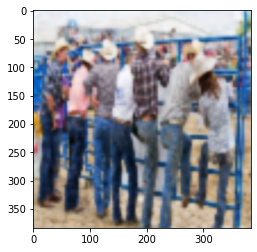

In [ ]:
from keras.preprocessing.image import array_to_img

esrgan_pre_gen_pred = generator.predict(np.array([LR_val[0]]))
plt.imshow(array_to_img(esrgan_pre_gen_pred.reshape(high_shape)*255))

In [ ]:
from keras.models import load_model

losses = Losses()
generator = load_model(gen_model_path, 
                       custom_objects={"mse_loss": losses.mse_loss})

vgg = VGG.build()
discriminator = ESRGAN.discriminator(feature_maps=FEATURE_MAPS, 
                                     leaky_alpha=LEAKY_ALPHA, 
                                     disc_blocks=DISC_BLOCKS)

esrgan = ESRGANTraining(generator=generator, discriminator=discriminator, 
                        vgg=vgg, batch_size=TRAIN_BATCH_SIZE)

esrgan.compile(discriminator_optimizer=Adam(learning_rate=FINETUNE_LR),
               generator_optimizer=Adam(learning_rate=FINETUNE_LR),
               bce_loss=losses.bce_loss,
               mse_loss=losses.mse_loss)

print("[INFO] training ESRGAN...")
esrgan.fit(LR_train, HR_train, epochs=FINETUNE_EPOCHS, batch_size=TRAIN_BATCH_SIZE)

print("[INFO] saving ESRGAN generator to {}...".format(ESRGAN_model_path))
esrgan.generator.save(ESRGAN_model_path)

80150528/80134624 [==============================] - 0s 0us/step
[INFO] training ESRGAN...
Epoch 1/1000


2022-09-12 21:45:40.713068: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.19GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.
2022-09-12 21:45:41.317763: W tensorflow/core/common_runtime/bfc_allocator.cc:272] Allocator (GPU_0_bfc) ran out of memory trying to allocate 2.55GiB with freed_by_count=0. The caller indicates that this is not a failure, but may mean that there could be performance gains if more memory were available.


9/9 [==============================] - 27s 1s/step - d_loss: 0.6932 - g_total_loss: 0.5844 - g_loss: 0.6931 - perc_loss: 0.0253 - pixel_loss: 55.5626
Epoch 2/1000
9/9 [==============================] - 13s 1s/step - d_loss: 0.6931 - g_total_loss: 0.4300 - g_loss: 0.6932 - perc_loss: 0.0251 - pixel_loss: 40.1438
Epoch 3/1000
9/9 [==============================] - 12s 1s/step - d_loss: 0.6931 - g_total_loss: 0.3630 - g_loss: 0.6932 - perc_loss: 0.0251 - pixel_loss: 33.4493
Epoch 4/1000
9/9 [==============================] - 13s 1s/step - d_loss: 0.6931 - g_total_loss: 0.3165 - g_loss: 0.6932 - perc_loss: 0.0241 - pixel_loss: 28.8991
Epoch 5/1000
9/9 [==============================] - 13s 1s/step - d_loss: 0.6930 - g_total_loss: 0.3034 - g_loss: 0.6933 - perc_loss: 0.0245 - pixel_loss: 27.5432
Epoch 6/1000
9/9 [==============================] - 12s 1s/step - d_loss: 0.6929 - g_total_loss: 0.2987 - g_loss: 0.6934 - perc_loss: 0.0238 - pixel_loss: 27.1392
Epoch 7/1000
9/9 [=================

In [ ]:
lr_image, hr_image = LR_val, HR_val

print("[INFO] loading the pre-trained and fully trained ESRGAN model...")
esrgan_pre_gen = load_model(gen_model_path, compile=False)
esrgan_gen = load_model(ESRGAN_model_path, compile=False)

print("[INFO] making predictions with pre-trained and fully trained ESRGAN model...")
esrgan_pre_gen_pred = esrgan_pre_gen.predict(lr_image)
esrgan_gen_pred = esrgan_gen.predict(hr_image)

[INFO] loading the pre-trained and fully trained ESRGAN model...
[INFO] making predictions with pre-trained and fully trained ESRGAN model...


In [ ]:
from matplotlib.pyplot import subplots, savefig, title, xticks, yticks, show
from keras.preprocessing.image import array_to_img
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import os

def zoom_into_images(image, imageTitle):
    (fig, ax) = subplots()
    im = ax.imshow(array_to_img(image[::-1]), origin="lower")
    title(imageTitle)

    axins = zoomed_inset_axes(ax, 2, loc=2)
    axins.imshow(array_to_img(image[::-1]), origin="lower")

    (x1, x2, y1, y2) = 20, 40, 20, 40

    axins.set_xlim(x1, x2)

    axins.set_ylim(y1, y2)

    yticks(visible=False)
    xticks(visible=False)

    mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")

    imagePath = os.path.join(BASE_IMAGE_PATH, f"{imageTitle}.png")
    savefig(imagePath)

    show()

[INFO] plotting the ESRGAN predictions...
[INFO] saving the ESRGAN predictions to disk...


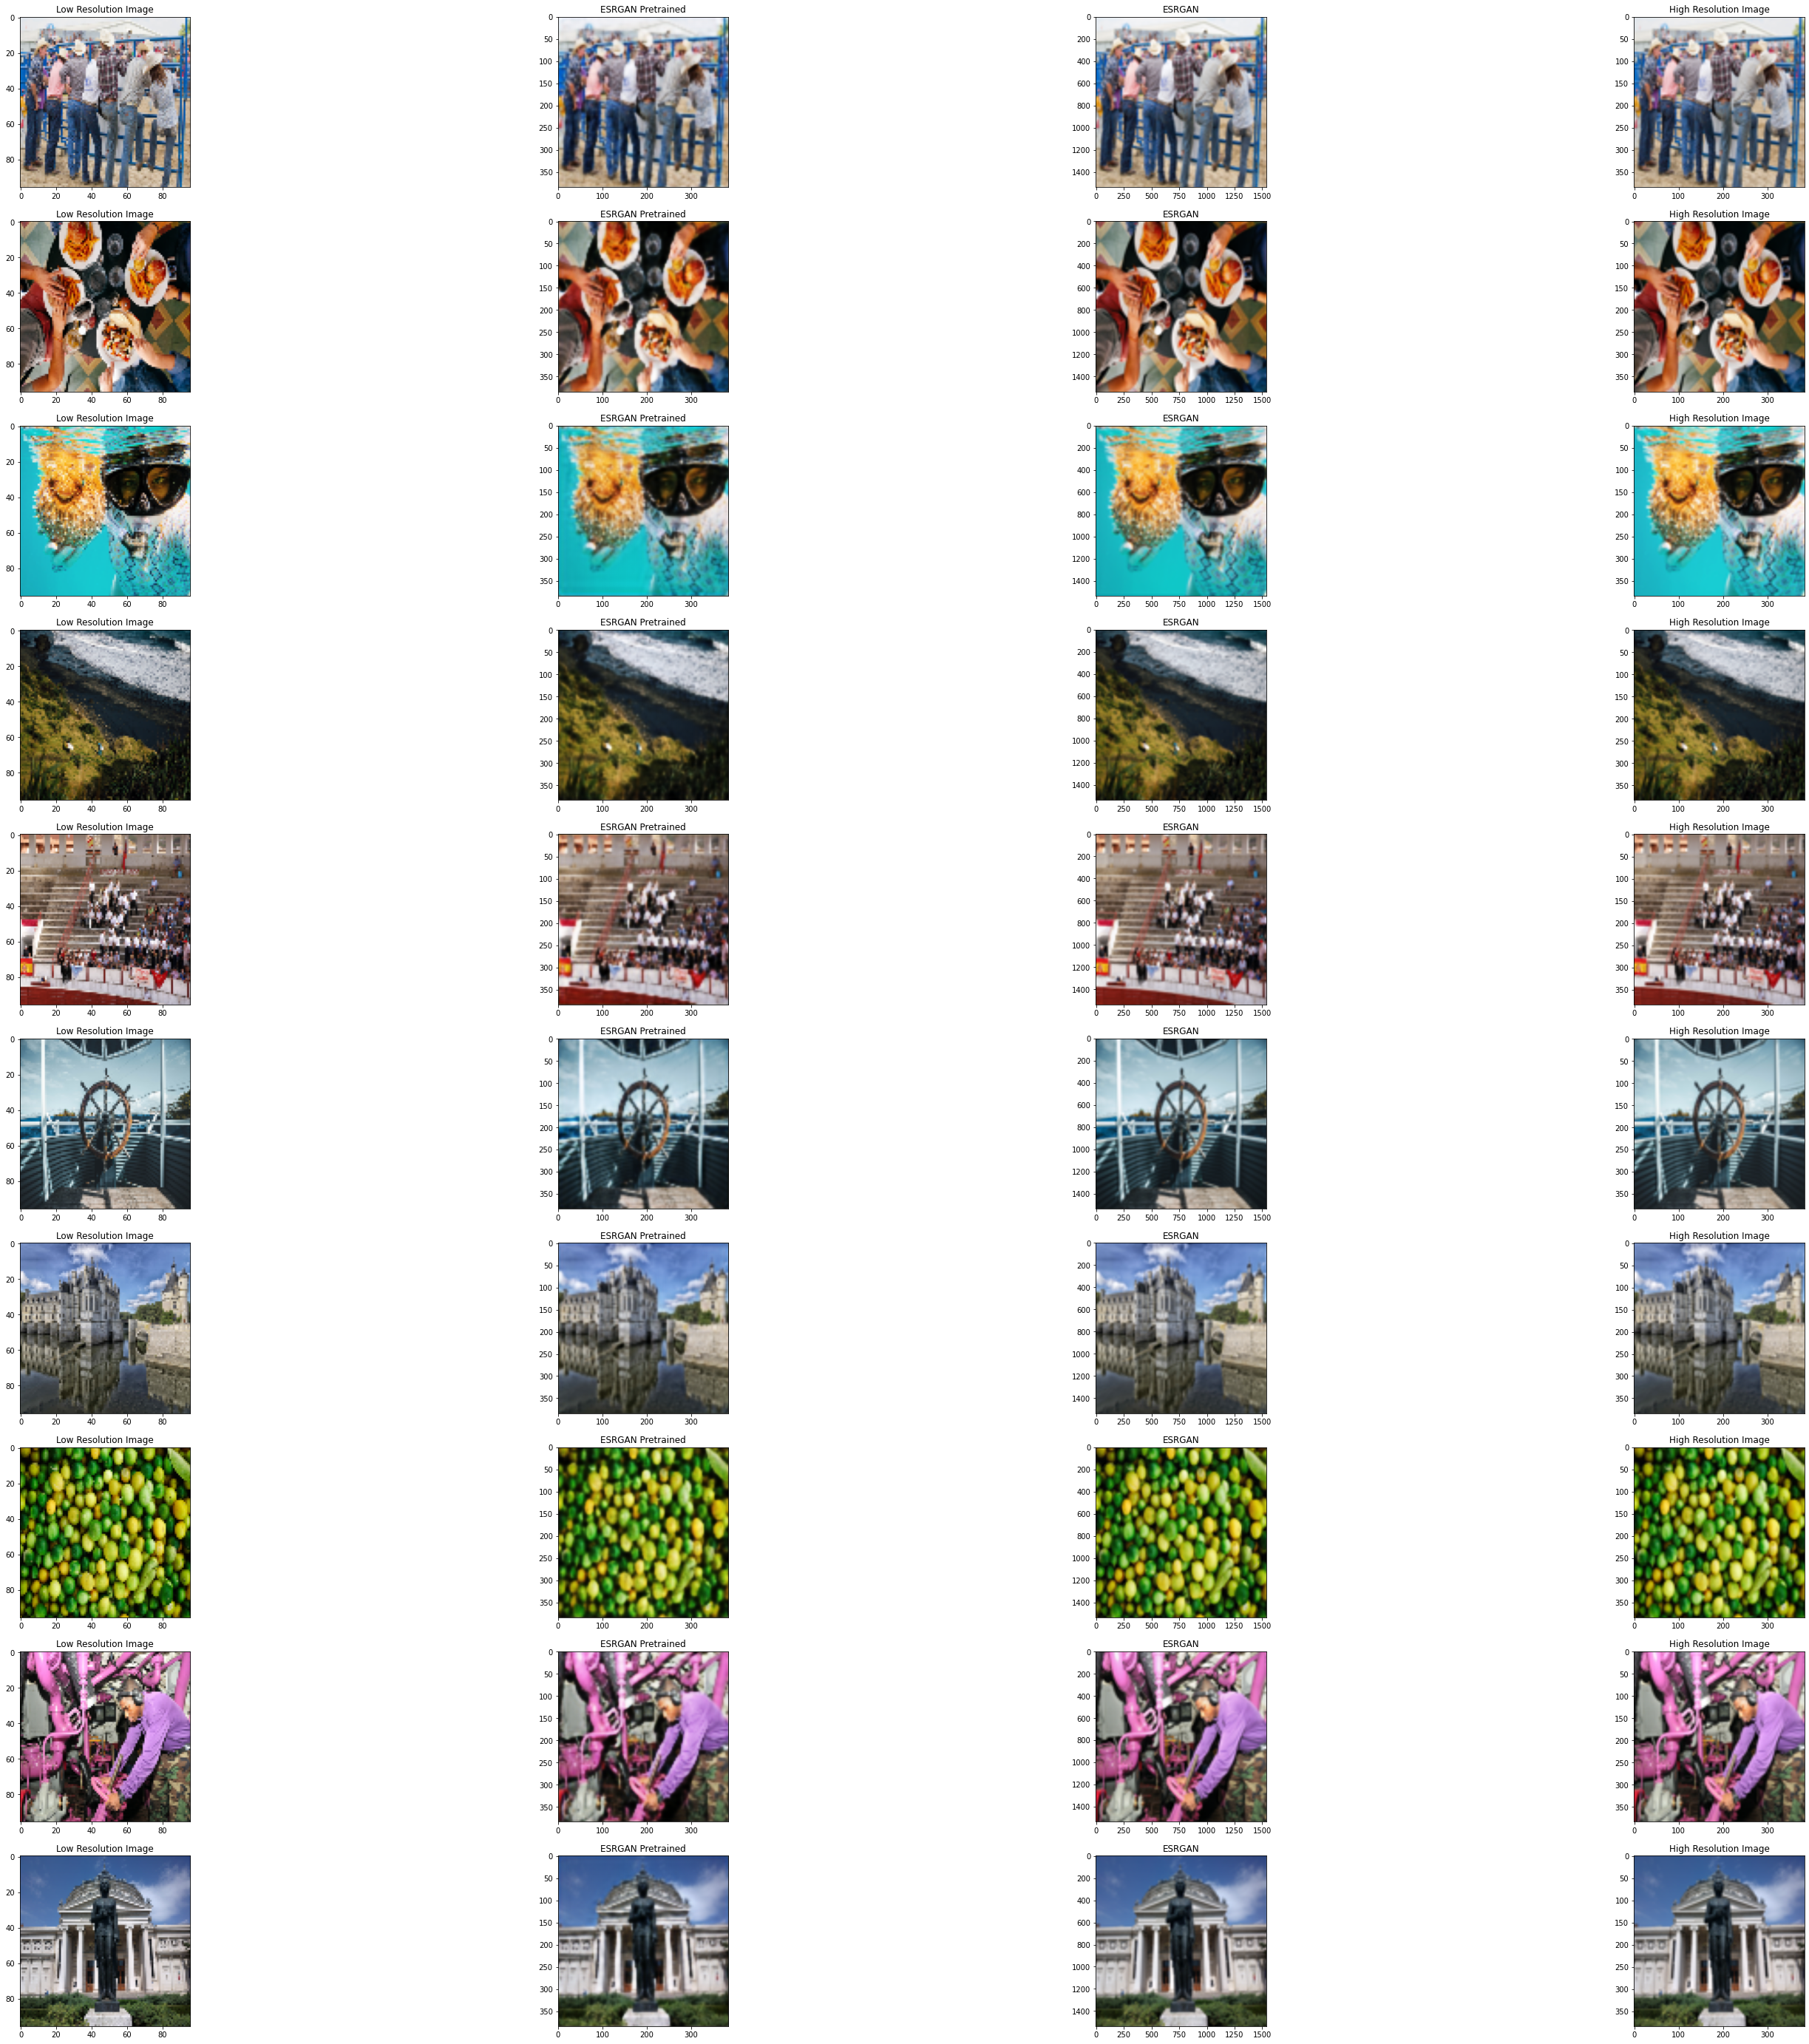

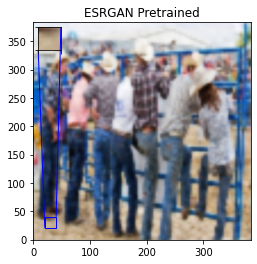

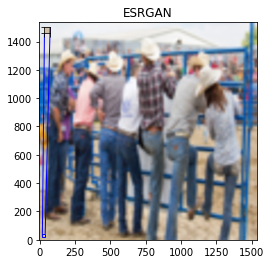

In [ ]:
GRID_IMAGE_PATH = os.path.join(BASE_IMAGE_PATH, "grid.png")

print("[INFO] plotting the ESRGAN predictions...")
(fig, axes) = subplots(nrows=INFER_BATCH_SIZE, ncols=4,figsize=(50, 50))

for (ax, lowRes, esrPreIm, esrGanIm, highRes) in zip(axes, 
                                                     lr_image, esrgan_pre_gen_pred, 
                                                     esrgan_gen_pred, hr_image):
    ax[0].imshow(array_to_img(lowRes))
    ax[0].set_title("Low Resolution Image")

    ax[1].imshow(array_to_img(esrPreIm))
    ax[1].set_title("ESRGAN Pretrained")

    ax[2].imshow(array_to_img(esrGanIm))
    ax[2].set_title("ESRGAN")

    ax[3].imshow(array_to_img(highRes))
    ax[3].set_title("High Resolution Image")

if not os.path.exists(BASE_IMAGE_PATH):
    os.makedirs(BASE_IMAGE_PATH)

print("[INFO] saving the ESRGAN predictions to disk...")
fig.savefig(GRID_IMAGE_PATH)

zoom_into_images(esrgan_pre_gen_pred[0], "ESRGAN Pretrained")
zoom_into_images(esrgan_gen_pred[0], "ESRGAN")